<a href="https://colab.research.google.com/github/mithleshsingla/projects/blob/main/Cv_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

# Downloading all the required libraries


# Importing all the required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import style
from glob import glob
from natsort import natsorted
from tqdm import tqdm
style.use('ggplot')

Mounted at /content/drive


In [ ]:
# Loading all the images in the drive
gt_images = []

for files in tqdm(natsorted(glob('/content/drive/My Drive/ES666CV/images/A/*'))):
    gt_images.append(cv2.imread(files, 1))

gt_images = np.array(gt_images) # Only possible because all images are of same size

100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


In [ ]:
def show_image_grid(images, M, N, title='Title'):
    # Assuming 'images' is a numpy array of shape (num_images, height, width, channels)
    fig, axes = plt.subplots(M, N, figsize=(N * 2, M * 2))

    if len(images.shape) < 4:
        images = np.expand_dims(images.copy(), axis=0)

    fig.suptitle(title)
    for i in range(M):
        for j in range(N):
            if M==1 and N==1:
                ax = axes
            elif M == 1 or N==1:
                ax = axes[max(i, j)]
            else:
                ax = axes[i, j]
            index = i * N + j
            if index < images.shape[0]:
                ax.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
            ax.axis('off')
    plt.tight_layout()
    plt.show()

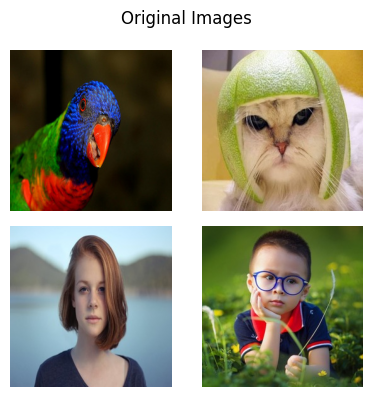

In [ ]:
show_image_grid(gt_images, 2, 2, 'Original Images')

In [ ]:
gt_images[0].shape

(256, 256, 3)

Given some set of images, you have to add two different kind of noises to it.
* Impulse noise (Salt and Pepper noise)
* Gaussian noise

<br/>
 Implementing all the noise addition algorithm from scratch.



In [ ]:
def add_impulse_noise(image, noise_prob):
    hp,vp,_=image.shape
    noise_ele=int(noise_prob*hp*vp)
    noisy_image=image.copy()
    for _ in range(noise_ele):
      if np.random.rand()>0.5:
        i=np.random.randint(0,hp)
        j=np.random.randint(0,vp)
        noisy_image[i,j]=[255,255,255]
      else:
        i=np.random.randint(0,hp)
        j=np.random.randint(0,vp)
        noisy_image[i,j]=[0,0,0]
    return noisy_image

def add_gaussian_noise(image, mean, std):
  gn=np.random.normal(mean,std,image.shape).astype('uint8')
  noisy_image=cv2.add(image,gn)
  noisy_image = np.clip(noisy_image, 0, 255).astype('uint8')
  return noisy_image

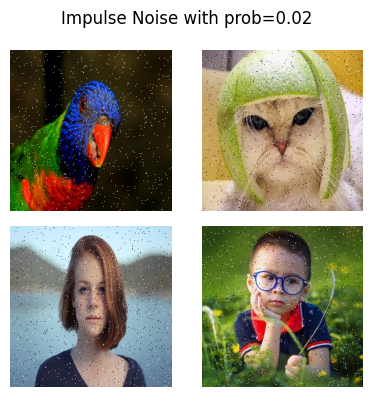

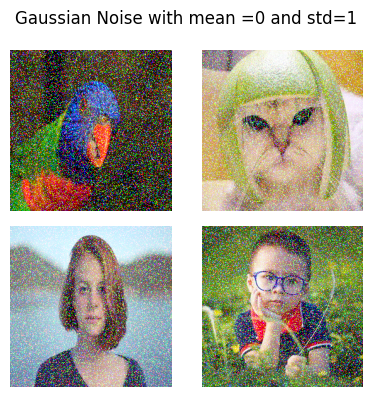

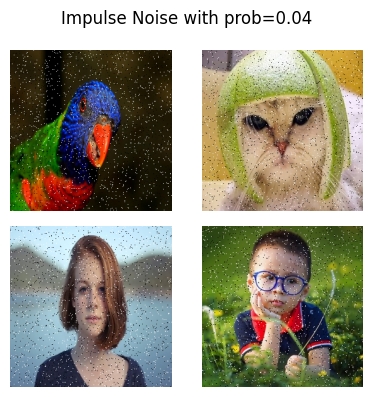

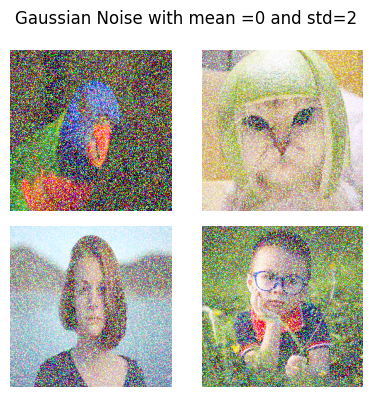

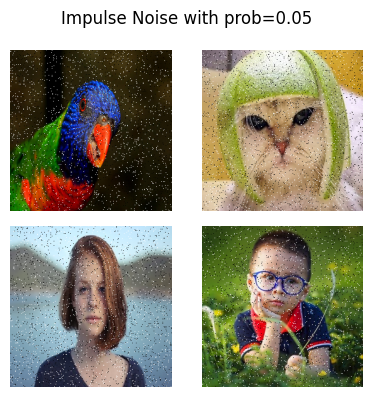

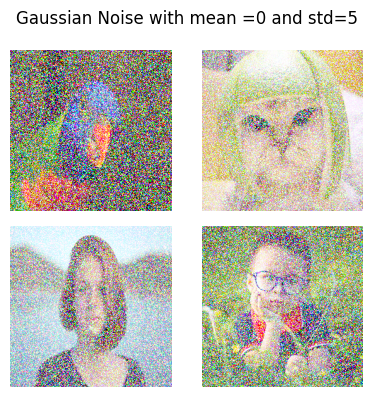

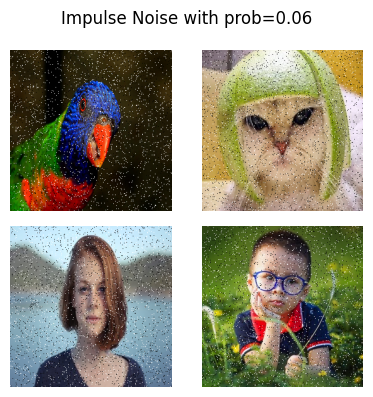

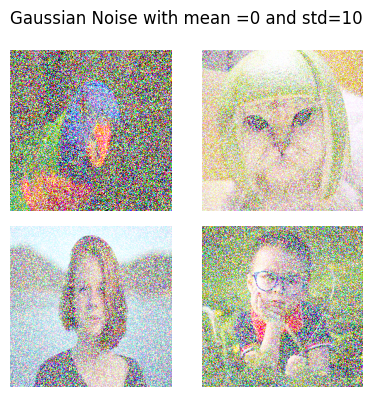

In [ ]:
# Write code here
impulse_noisy_images  = []
gaussian_noisy_images = []

noise_prob=[0.02,0.04,0.05,0.06]
std=[1,2,5,10]
for i in range(4):
  for image in gt_images:
    impulse_noisy_images.append(add_impulse_noise(image, noise_prob[i]))
    gaussian_noisy_images.append(add_gaussian_noise(image, mean=0, std=std[i]))

impulse_noisy_images = np.array(impulse_noisy_images)
gaussian_noisy_images = np.array(gaussian_noisy_images)
for i in range(4):
  show_image_grid(impulse_noisy_images[4*i:4*i+4], M=2, N=2, title=f'Impulse Noise with prob={noise_prob[i]}')
  show_image_grid(gaussian_noisy_images[4*i:4*i+4], M=2, N=2, title=f'Gaussian Noise with mean =0 and std={std[i]}')

Useing three different filtering operations and denoise the noisy images generated in the previous section. i have to use following noises value for this and rest of the question.
<pre>
noise_prob: 0.05 (impulse noise)
gaussian noise: mean = 0, std = 30
</pre>

* Box Filter: Moving Average Filter

[![boxfilter.webp](https://i.postimg.cc/4NtD4Z7k/boxfilter.webp)](https://postimg.cc/9rm816YJ)

* Gaussian Filter

[![gaussian.png](https://i.postimg.cc/Kvy9NTzw/gaussian.png)](https://postimg.cc/NLp7G5Rk)

* Median Filter

[![median.png](https://i.postimg.cc/q704Hqj5/median.png)](https://postimg.cc/NKNW1sh6)



 Implementing all the filters algorithm from scratch.

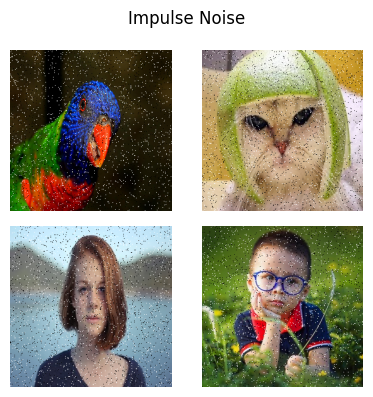

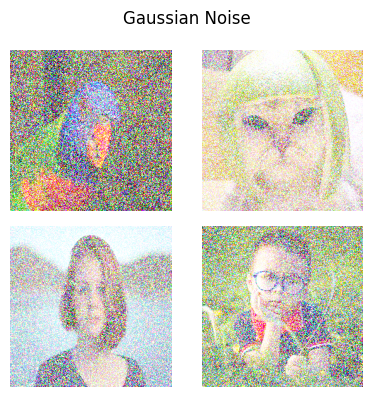

In [ ]:

impulse_noisy_images  = []
gaussian_noisy_images = []

for image in gt_images:
    impulse_noisy_images.append(add_impulse_noise(image, noise_prob=0.05))
    gaussian_noisy_images.append(add_gaussian_noise(image, mean=0., std=30))

impulse_noisy_images = np.array(impulse_noisy_images)
gaussian_noisy_images = np.array(gaussian_noisy_images)

show_image_grid(impulse_noisy_images, M=2, N=2, title='Impulse Noise')
show_image_grid(gaussian_noisy_images, M=2, N=2, title='Gaussian Noise')

In [ ]:
def apply_box_filter(image, kernel_size):
    padded=np.pad(image,(((kernel_size//2),(kernel_size//2)),((kernel_size//2),(kernel_size//2)),(0, 0)),mode='constant', constant_values=0)
    kernel=np.ones(((kernel_size),(kernel_size)))/(kernel_size*kernel_size)
    blurred_image = np.zeros_like(image)
    for c in range(image.shape[2]):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                region = padded[i:i+kernel_size, j:j+kernel_size, c]
                blurred_image[i, j, c] = np.sum(region * kernel)
    return blurred_image


def apply_gaussain_filter(image, kernel_size, sigma):
    padded=np.pad(image,(((kernel_size//2),(kernel_size//2)),((kernel_size//2),(kernel_size//2)),(0, 0)),mode='constant',constant_values=0)
    a=np.zeros((kernel_size,kernel_size))
    blurred_image = np.zeros_like(image)
    for i in range(kernel_size):
      for j in range(kernel_size):
        x=i-kernel_size // 2
        y=j-kernel_size // 2
        a[i,j]=(np.exp(-1*(x**2+y**2)/(2*(sigma**2))))/(2*np.pi*(sigma**2))
    kernel=a/np.sum(a)
    for c in range(image.shape[2]):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                region = padded[i:i+kernel_size, j:j+kernel_size, c]
                blurred_image[i, j, c] = np.sum(region * kernel)
    return blurred_image


def apply_median_filter(image, kernel_size):
    padded=np.pad(image,(((kernel_size//2),(kernel_size//2)),((kernel_size//2),(kernel_size//2)),(0, 0)),mode='constant',constant_values=0)
    hp,vp,c=padded.shape
    filtered_image=np.zeros_like(image)
    for k in range(c):
      for i in range(kernel_size//2,hp-kernel_size//2):
        for j in range(kernel_size//2,vp-kernel_size//2):
          kernel=padded[i-(kernel_size//2):i+(kernel_size//2)+1,j-(kernel_size//2):j+(kernel_size//2)+1,k]
          med=np.median(kernel)
          filtered_image[i-(kernel_size//2),j-(kernel_size//2),k]=med
    return filtered_image

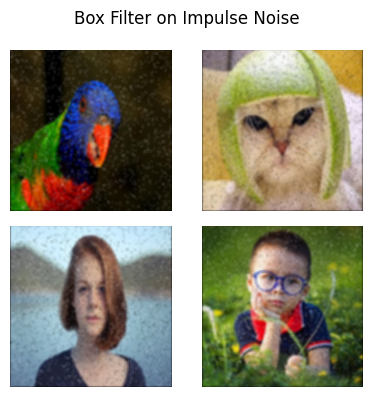

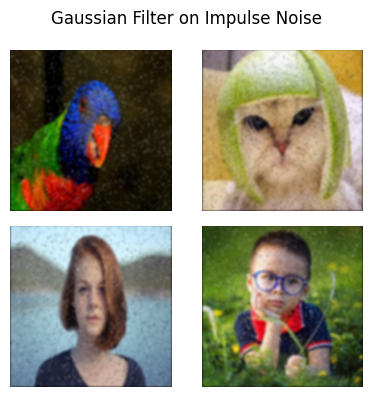

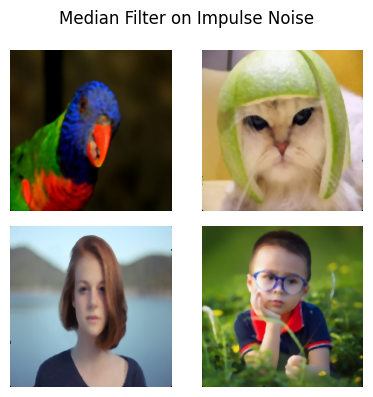

In [ ]:

box_filter_images_impulse       = []
gaussian_filter_images_impulse  = []
median_filter_images_impulse    = []

for image in impulse_noisy_images:
    box_filter_images_impulse.append(apply_box_filter(image, kernel_size=5))
    gaussian_filter_images_impulse.append(apply_gaussain_filter(image, kernel_size=7, sigma=2.0))
    median_filter_images_impulse.append(apply_median_filter(image, kernel_size=5))

box_filter_images_impulse = np.array(box_filter_images_impulse)
gaussian_filter_images_impulse = np.array(gaussian_filter_images_impulse)
median_filter_images_impulse = np.array(median_filter_images_impulse)

show_image_grid(box_filter_images_impulse, M=2, N=2, title='Box Filter on Impulse Noise')
show_image_grid(gaussian_filter_images_impulse, M=2, N=2, title='Gaussian Filter on Impulse Noise')
show_image_grid(median_filter_images_impulse, M=2, N=2, title='Median Filter on Impulse Noise')

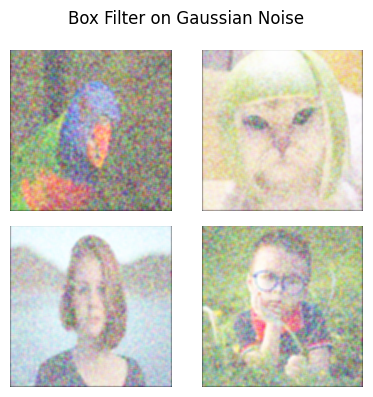

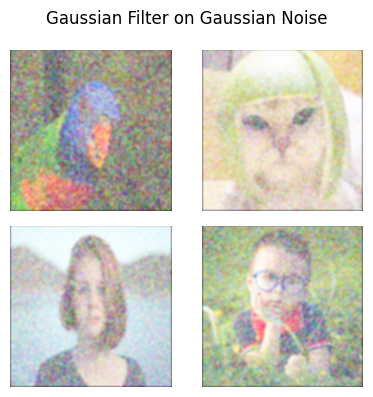

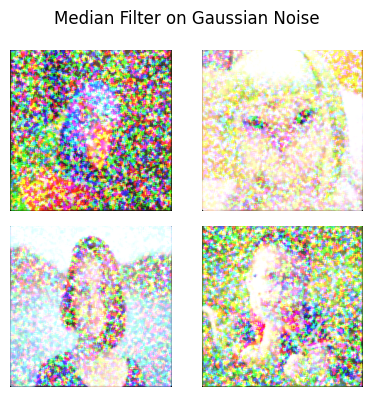

In [ ]:
# Write code here
box_filter_images_gaussian       = []
gaussian_filter_images_gaussian  = []
median_filter_images_gaussian    = []

for image in gaussian_noisy_images:
    box_filter_images_gaussian.append(apply_box_filter(image, kernel_size=5))
    gaussian_filter_images_gaussian.append(apply_gaussain_filter(image, kernel_size=7, sigma=2.0))
    median_filter_images_gaussian.append(apply_median_filter(image, kernel_size=5))

box_filter_images_gaussian = np.array(box_filter_images_gaussian)
gaussian_filter_images_gaussian = np.array(gaussian_filter_images_gaussian)
median_filter_images_gaussian = np.array(median_filter_images_gaussian)

show_image_grid(box_filter_images_gaussian, M=2, N=2, title='Box Filter on Gaussian Noise')
show_image_grid(gaussian_filter_images_gaussian, M=2, N=2, title='Gaussian Filter on Gaussian Noise')
show_image_grid(median_filter_images_gaussian, M=2, N=2, title='Median Filter on Gaussian Noise')

Implementing the Canny Edge Detector algorithm from scratch<br/><br/>
Compareing  implementation with Opencv canny edge detector method by
creating a table of 6 x 4 (where 6 is all the filters and 4 is number of images) and show Root Mean Square Error between your canny edge image and opencv canny edge image.

In [ ]:
def apply_canny_edge_detector_opencv(image, threshold1, threshold2):

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply the Canny edge detector
    edges = cv2.Canny(gray_image, threshold1, threshold2)

    # This is done only for converting 1 channel image to 3 channels for
    # visualization purpose in matplotlib
    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    return edges

def apply_canny_edge_detector_self(image, threshold1, threshold2):
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  def apply_gaussain_filter(image):
    padded = np.pad(image,((2, 2),(2, 2)),mode='constant', constant_values=0)
    a=np.zeros((5,5))
    blurred_image = np.zeros_like(image)
    for i in range(5):
      for j in range(5):
        x=i-2
        y=j-2
        a[i,j]=(np.exp(-1*(x**2+y**2)/(2*(1**2))))/(2*np.pi*(1**2))
    kernel=a/np.sum(a)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded[i:i+5, j:j+5]
            blurred_image[i, j] = np.sum(region * kernel)
    return blurred_image

  blurred_image=apply_gaussain_filter(gray_image)


  def sobel_filter(image):
    Fx=np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    padded = np.pad(image,((1, 1),(1, 1)),mode='constant', constant_values=0)
    x_filtered_image = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region=padded[i:i+3, j:j+3]
            x_filtered_image[i, j] = np.sum(region*Fx)

    Fy= np.array([[1,2,1],[0,0,0],[-1,-2,-1]])

    y_filtered_image = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region=padded[i:i+3, j:j+3]
            y_filtered_image[i, j] = np.sum(region*Fy)

    Grad=np.hypot(x_filtered_image, y_filtered_image)
    Grad=(Grad/Grad.max())*255
    theta=np.arctan2(y_filtered_image,x_filtered_image)

    return (Grad,theta)

  g,t=sobel_filter(blurred_image)

  def supression(g,t):
    h,v=g.shape
    supressed_image=np.zeros((h,v))
    angle=t*180./np.pi
    angle[angle<0]+=180
    for i in range(1,h-1):
      for j in range(1,v-1):
        if 0<=angle[i,j]<22.5 or 157.5<=angle[i,j]<=180:
          q=g[i,j+1]
          r=g[i,j-1]
        elif 22.5<=angle[i,j]<67.5:
          q=g[i-1,j+1]
          r=g[i+1,j-1]
        elif 67.5<=angle[i,j]<112.5:
          q=g[i-1,j]
          r=g[i+1,j]
        elif 112.5<=angle[i,j]<157.5:
          q=g[i-1,j-1]
          r=g[i+1,j+1]
        if g[i,j]>q and g[i,j]>r:
          supressed_image[i,j]=g[i,j]
        else:
          supressed_image[i,j]=0
    return supressed_image

  supressed_image=supression(g,t)

  def threshhold(image):
       th_image=np.zeros_like(image)
       str_i,str_j=np.where(image>threshold2)
       wek_i,wek_j=np.where((image>threshold1) & (image<threshold2))
       th_image[str_i,str_j]=255
       th_image[wek_i,wek_j]=100
       return th_image

  th_image=threshhold(supressed_image)

  def hypothesis(image):
    m,n=image.shape
    for i in range(1,m-1):
      for j in range(1,n-1):
        if image[i,j]==100:
            if  image[i-1,j-1]==255 or  image[i-1,j]==255 or image[i-1,j+1]==255 or image[i,j-1]==255 or image[i+1,j]==255 or  image[i,j+1]==255 or image[i+1,j+1]==255 or image[i+1,j-1]==255 :
                  image[i,j]=255
            else :
                  image[i,j]=0
    return image

  edges=hypothesis(th_image)


    # This is done only for converting 1 channel image to 3 channels for
    # visualization purpose in matplotlib
  edges = cv2.cvtColor(edges.astype(np.uint8), cv2.COLOR_GRAY2BGR)

  return edges

In [ ]:
threshold1 = 80
threshold2 = 180

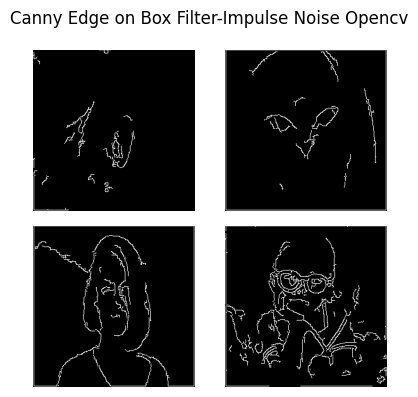

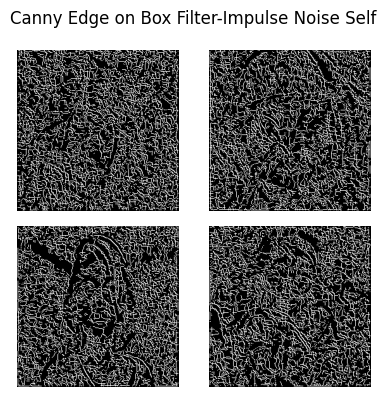

In [ ]:

canny_edge_opencv_box_filter_images_impulse = []
canny_edge_self_box_filter_images_impulse = []

for image in box_filter_images_impulse:
    canny_edge_opencv_box_filter_images_impulse.append(apply_canny_edge_detector_opencv(image, threshold1=threshold1, threshold2=threshold2))
    canny_edge_self_box_filter_images_impulse.append(apply_canny_edge_detector_self(image, threshold1=threshold1, threshold2=threshold2))

canny_edge_box_filter_images_impulse = np.array(canny_edge_opencv_box_filter_images_impulse)
canny_edge_self_box_filter_images_impulse = np.array(canny_edge_self_box_filter_images_impulse)

show_image_grid(canny_edge_box_filter_images_impulse, M=2, N=2, title='Canny Edge on Box Filter-Impulse Noise Opencv')
show_image_grid(canny_edge_self_box_filter_images_impulse, M=2, N=2, title='Canny Edge on Box Filter-Impulse Noise Self')

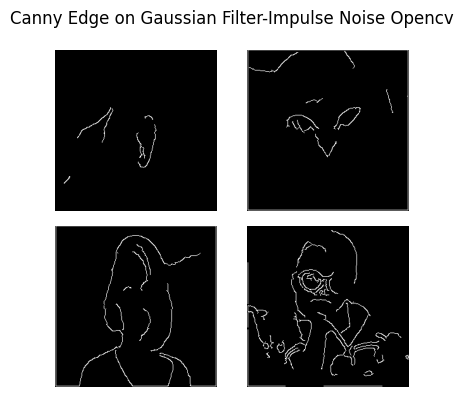

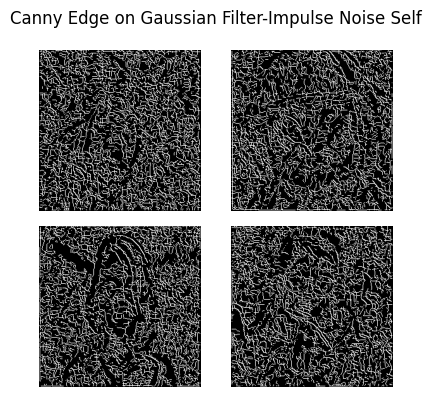

In [ ]:
canny_edge_opencv_gaussian_filter_images_impulse = []
canny_edge_self_gaussian_filter_images_impulse = []

for image in gaussian_filter_images_impulse:
    canny_edge_opencv_gaussian_filter_images_impulse.append(apply_canny_edge_detector_opencv(image, threshold1=threshold1, threshold2=threshold2))
    canny_edge_self_gaussian_filter_images_impulse.append(apply_canny_edge_detector_self(image, threshold1=threshold1, threshold2=threshold2))

canny_edge_gaussian_filter_images_impulse = np.array(canny_edge_opencv_gaussian_filter_images_impulse)
canny_edge_self_gaussian_filter_images_impulse = np.array(canny_edge_self_gaussian_filter_images_impulse)

show_image_grid(canny_edge_gaussian_filter_images_impulse, M=2, N=2, title='Canny Edge on Gaussian Filter-Impulse Noise Opencv')
show_image_grid(canny_edge_self_gaussian_filter_images_impulse, M=2, N=2, title='Canny Edge on Gaussian Filter-Impulse Noise Self')

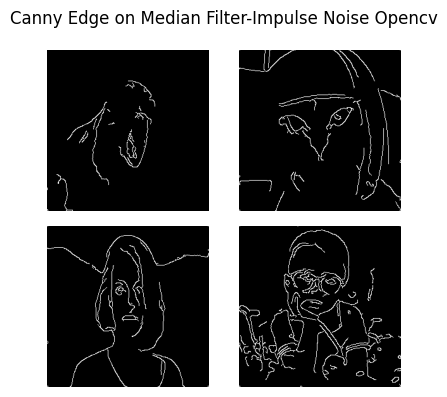

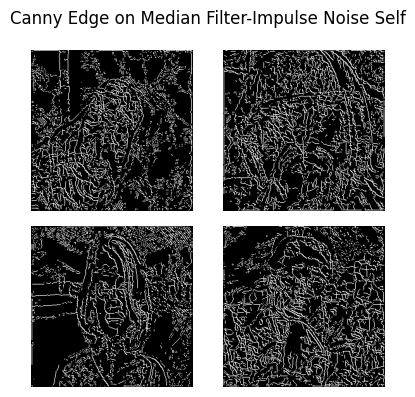

In [ ]:
canny_edge_opencv_median_filter_images_impulse = []
canny_edge_self_median_filter_images_impulse = []

for image in median_filter_images_impulse:
    canny_edge_opencv_median_filter_images_impulse.append(apply_canny_edge_detector_opencv(image, threshold1=threshold1, threshold2=threshold2))
    canny_edge_self_median_filter_images_impulse.append(apply_canny_edge_detector_self(image, threshold1=threshold1, threshold2=threshold2))

canny_edge_median_filter_images_impulse = np.array(canny_edge_opencv_median_filter_images_impulse)
canny_edge_self_median_filter_images_impulse = np.array(canny_edge_self_median_filter_images_impulse)

show_image_grid(canny_edge_median_filter_images_impulse, M=2, N=2, title='Canny Edge on Median Filter-Impulse Noise Opencv')
show_image_grid(canny_edge_self_median_filter_images_impulse, M=2, N=2, title='Canny Edge on Median Filter-Impulse Noise Self')

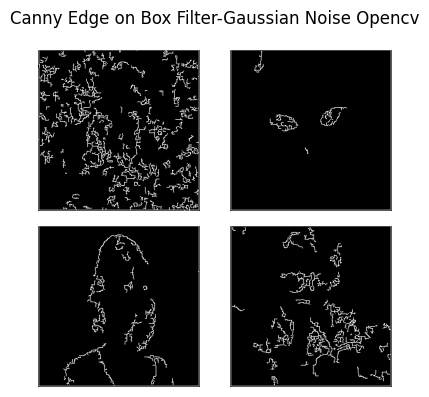

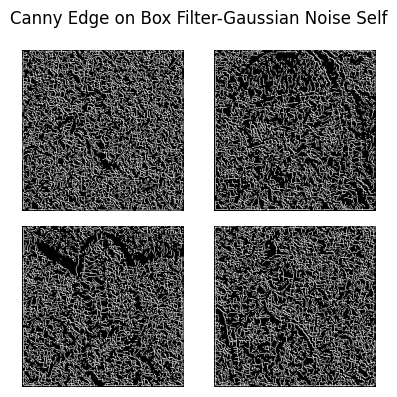

In [ ]:
canny_edge_opencv_box_filter_images_gaussian = []
canny_edge_self_box_filter_images_gaussian = []

for image in box_filter_images_gaussian:
    canny_edge_opencv_box_filter_images_gaussian.append(apply_canny_edge_detector_opencv(image, threshold1=threshold1, threshold2=threshold2))
    canny_edge_self_box_filter_images_gaussian.append(apply_canny_edge_detector_self(image, threshold1=threshold1, threshold2=threshold2))

canny_edge_box_filter_images_gaussian = np.array(canny_edge_opencv_box_filter_images_gaussian)
canny_edge_self_box_filter_images_gaussian = np.array(canny_edge_self_box_filter_images_gaussian)

show_image_grid(canny_edge_box_filter_images_gaussian, M=2, N=2, title='Canny Edge on Box Filter-Gaussian Noise Opencv')
show_image_grid(canny_edge_self_box_filter_images_gaussian, M=2, N=2, title='Canny Edge on Box Filter-Gaussian Noise Self')

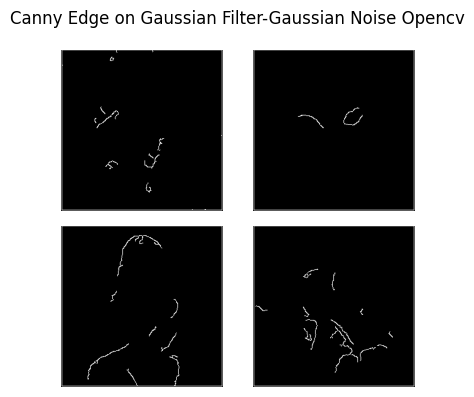

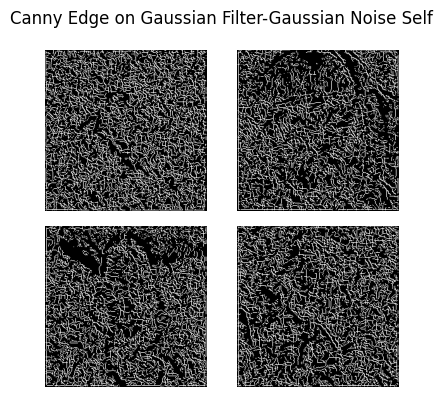

In [ ]:
canny_edge_opencv_gaussian_filter_images_gaussian = []
canny_edge_self_gaussian_filter_images_gaussian = []

for image in gaussian_filter_images_gaussian:
    canny_edge_opencv_gaussian_filter_images_gaussian.append(apply_canny_edge_detector_opencv(image, threshold1=threshold1, threshold2=threshold2))
    canny_edge_self_gaussian_filter_images_gaussian.append(apply_canny_edge_detector_self(image, threshold1=threshold1, threshold2=threshold2))

canny_edge_gaussian_filter_images_gaussian = np.array(canny_edge_opencv_gaussian_filter_images_gaussian)
canny_edge_self_gaussian_filter_images_gaussian = np.array(canny_edge_self_gaussian_filter_images_gaussian)

show_image_grid(canny_edge_gaussian_filter_images_gaussian, M=2, N=2, title='Canny Edge on Gaussian Filter-Gaussian Noise Opencv')
show_image_grid(canny_edge_self_gaussian_filter_images_gaussian, M=2, N=2, title='Canny Edge on Gaussian Filter-Gaussian Noise Self')

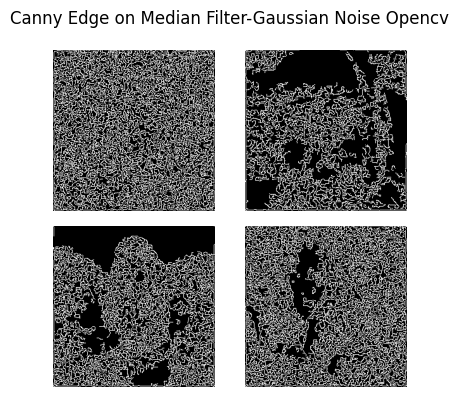

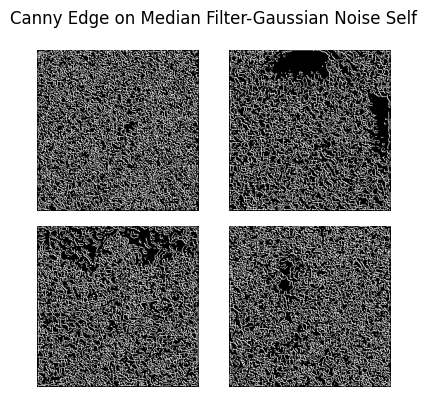

In [ ]:
canny_edge_opencv_median_filter_images_gaussian = []
canny_edge_self_median_filter_images_gaussian = []

for image in median_filter_images_gaussian:
    canny_edge_opencv_median_filter_images_gaussian.append(apply_canny_edge_detector_opencv(image, threshold1=threshold1, threshold2=threshold2))
    canny_edge_self_median_filter_images_gaussian.append(apply_canny_edge_detector_self(image, threshold1=threshold1, threshold2=threshold2))

canny_edge_median_filter_images_gaussian = np.array(canny_edge_opencv_median_filter_images_gaussian)
canny_edge_self_median_filter_images_gaussian = np.array(canny_edge_self_median_filter_images_gaussian)

show_image_grid(canny_edge_median_filter_images_gaussian, M=2, N=2, title='Canny Edge on Median Filter-Gaussian Noise Opencv')
show_image_grid(canny_edge_self_median_filter_images_gaussian, M=2, N=2, title='Canny Edge on Median Filter-Gaussian Noise Self')

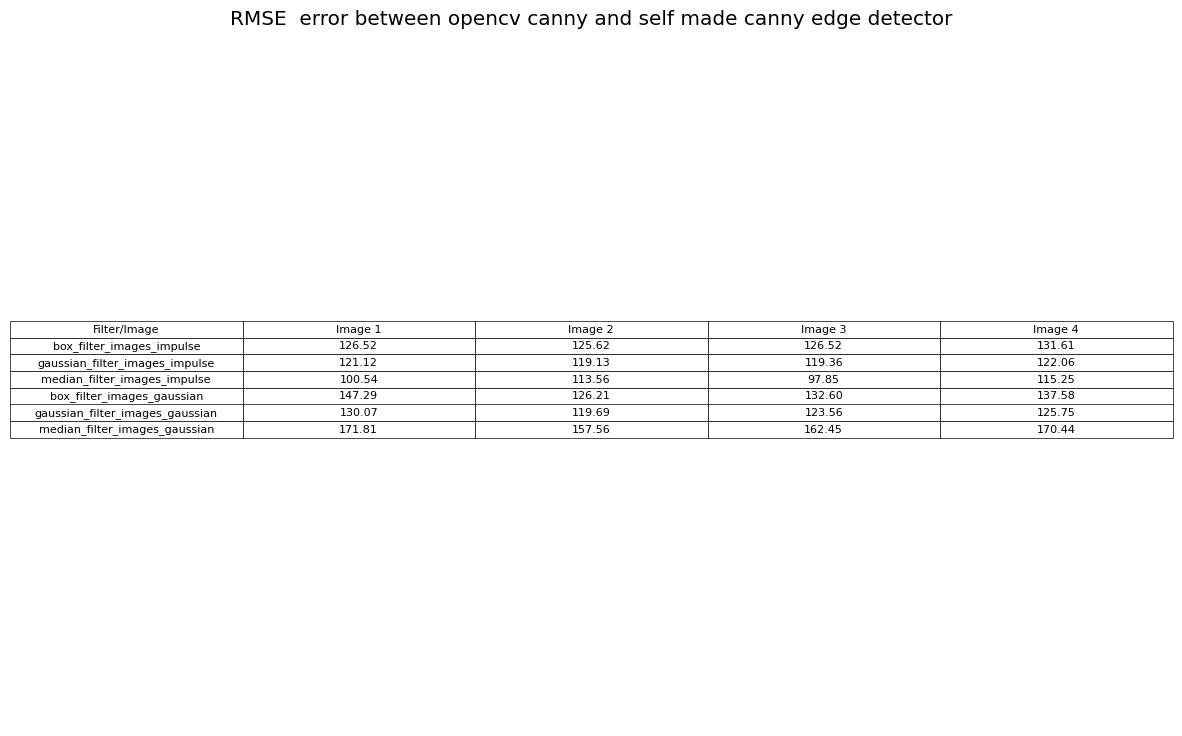

In [ ]:

def calculate_rmse(image1, image2):
    return np.sqrt(np.mean((image1.astype("float")- image2.astype("float"))**2))
result=np.zeros((6,4))

canny_edge_images = {'box_filter_images_impulse': canny_edge_box_filter_images_impulse,
'self_box_filter_images_impulse': canny_edge_self_box_filter_images_impulse,
'gaussian_filter_images_impulse': canny_edge_gaussian_filter_images_impulse,
'self_gaussian_filter_images_impulse': canny_edge_self_gaussian_filter_images_impulse,
'median_filter_images_impulse': canny_edge_median_filter_images_impulse,
'self_median_filter_images_impulse': canny_edge_self_median_filter_images_impulse,
'box_filter_images_gaussian': canny_edge_box_filter_images_gaussian,
'self_box_filter_images_gaussian': canny_edge_self_box_filter_images_gaussian,
'gaussian_filter_images_gaussian': canny_edge_gaussian_filter_images_gaussian,
'self_gaussian_filter_images_gaussian': canny_edge_self_gaussian_filter_images_gaussian,
'median_filter_images_gaussian': canny_edge_median_filter_images_gaussian,
'self_median_filter_images_gaussian': canny_edge_self_median_filter_images_gaussian,}

filters = [('box_filter_images_impulse','self_box_filter_images_impulse'),
('gaussian_filter_images_impulse','self_gaussian_filter_images_impulse'),
('median_filter_images_impulse','self_median_filter_images_impulse'),
('box_filter_images_gaussian','self_box_filter_images_gaussian'),
('gaussian_filter_images_gaussian','self_gaussian_filter_images_gaussian'),
('median_filter_images_gaussian','self_median_filter_images_gaussian')]

for i,(opencv_filter,self_filter) in enumerate(filters):
    for j in range(4):
        rmse=calculate_rmse(canny_edge_images[opencv_filter][j],canny_edge_images[self_filter][j])
        result[i, j]=rmse

fig, ax = plt.subplots(figsize=(15,9))
ax.axis('tight')
ax.axis('off')

table_data =[['Filter/Image'] + [f'Image {i+1}' for i in range(4)]]
table_data +=[[filter_name] + [f"{result[i, j]:.2f}" for j in range(4)] for i, (filter_name, _) in enumerate(filters)]
table =ax.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
plt.title("RMSE  error between opencv canny and self made canny edge detector")
plt.show()
